In this notebook, we will be looking at trail elevation profiles and using them to generate a new feature for our dataset. We will also be preparing data for the extraction of more complex features in the next notebook. First, let's open the dataset that we saved at the end of the previous notebook.

In [1]:
import pandas as pd

filename='../Data/hiking1.csv'
df=pd.read_csv(filename)
df.head()

,Rank,Name,Length,Elevation gain,Rocky,Stairs,Muddy,Roots,Avg_grade,Difficulty
0,1,Mount Yonah Trail,4.3,1489,1,0,0,0,0.065583,5.898734
1,2,East Palisades Trail and Bamboo Forest,4.2,495,0,0,0,1,0.022321,3.494382
2,3,Cloudland Canyon West Rim Loop,4.7,705,1,1,0,0,0.028409,3.869565
3,4,Tallulah Gorge and North and South Rim Loop Trail,1.8,534,1,1,0,0,0.056187,4.327273
4,5,Indian Seats Loop,3.5,508,1,0,0,0,0.027489,3.111498


Now let's look inside the hiking_trails directory and list the first few filenames in there.

In [2]:
import os

os.chdir('../Data/hiking_trails')
entries = os.listdir('.')
print(entries[0:5])

['Allatoona_Falls_Trail.csv', 'Amicalola_Falls.csv', 'Amicalola_Falls_Lookout_via_Creek_Trail_and_West_Ridge_Falls_Access.csv', 'Amicalola_Falls_Loop.csv', 'Amicalola_Falls_to_Len_Foote_Hike_Inn.csv']


These files contain trail elevation profiles and are accessible through the AllTrails website:

<img src="../Images/trail_download.png" width="600" height="300" style="display: block; margin: auto; max-width: 100%;" />

The download option may be found near the bottom of the trail's page. I chose to export the map files to .csv files.

The files in the directory are listed in alphabetical order, which is not the same order as the trails are listed in our starting dataset (i.e., by rank). Now let's look at the first entry in the list and show the first few rows.

In [3]:
df_example=pd.read_csv(entries[0]) #Allatoona Falls Trail
df_example.head()

,Latitude,Longitude,Elevation
0,34.13176,-84.52313,263.0
1,34.13180,-84.52306,262.0
2,34.13185,-84.52297,261.0
3,34.13189,-84.52290,260.0
4,34.13221,-84.52251,259.0


We have three columns: latitude, longitude, and elevation. To get a sense of what the profiles look like, let's plot an example.

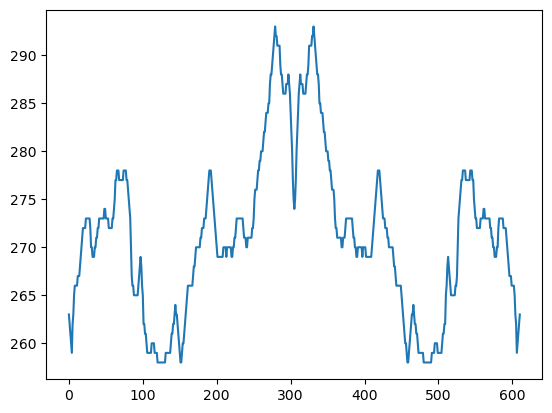

In [4]:
import matplotlib.pyplot as plt

df_example['Elevation'].plot()
plt.show()

Notice that the x axis units simply correspond to the number of points in the file. Through comparison of the elevation values with known information about the trails, I found that the elevation is listed in meters. Also note that we are plotting total elevation, so in most cases the minimum value is greater that zero.

We can also directly compute the trail length from the latitude and longitude coordinates. We already have an approximate value in our dataset, but this is a good exercise and it gives us a more precise value for when we will compute the maximum grade. The procedure for converting latitude and longitude coordinates into a length consists of:
1. Computing the differences between coordinates at every step
2. Converting the differences between latitude and longitude into miles
3. Computing the Frobenius norm of the latitude and longitude mile differences to obtain overall mile differences
4. Computing the sum of the mile differences

Let's create a function called compute_trail_length that implements these steps and use it on the Allatoona Falls Trail example.

In [5]:
import numpy as np

def compute_trail_length(df):
    coords=np.asarray(df[['Latitude','Longitude']])
    deltas=np.append(np.zeros((1,2)),np.diff(coords,axis=0),axis=0)
    deltas[:,0]*=69 #conversion of latitude degrees to mi.
    deltas[:,1]*=69*np.cos(np.radians(coords[:,0])) #conversion of longitude degrees to mi.
    dists=np.linalg.norm(deltas,axis=1) #distances in mi. between consecutive points
    dist_total=max(np.cumsum(dists))

    return dist_total

dist_total=compute_trail_length(df_example)
print(dist_total)

3.0485976125941945


We get a final value of approximately 3.05 miles, which is close to the value of 3.1 miles listed on AllTrails. Now let's compute the maximum slope of the trail. To do this, we will need to provide an interval, which is essentially the delta x value over which delta y will be computed. For this case I'll use an interval value of 100 feet. We will then compute the max grade by computing rise over run once every n steps, where n is the number of steps required to reach the specified interval. Note: this approach assumes equal spacing between recorded elevation points (which is not true!), but nevertheless I've found this approach to be pretty effective.

In [6]:
def compute_max_grade(df,interval):
    dist_total=compute_trail_length(df)*5280 #trail length in feet
    elevation_array=np.asarray((df['Elevation']-min(df['Elevation']))*3.28084) #min-subtracted elevation profile in feet
    dist_array=np.linspace(0,dist_total,len(elevation_array))
    sampling_freq=int(interval/dist_array[1]) #slope will be computed every sampling_freq number of steps
    gradients=np.gradient(elevation_array[::sampling_freq],dist_array[::sampling_freq])
    max_grade=max(abs(gradients))

    return max_grade

max_grade=compute_max_grade(df_example,100)
print(max_grade)

0.24866281980152738


So for this example the max grade is approximately 0.25, or 25%. Now let's compute the max grade for all entries in the dataset by implementing a loop.

In [7]:
df['Max_grade']=None

for entry in entries:
    df_entry=pd.read_csv(entry)
    max_grade=compute_max_grade(df_entry,100)
    name_formatted=entry[:-4].replace('_',' ')
    df.loc[df['Name']==name_formatted,'Max_grade']=max_grade

The second part of this notebook is concerned with preparing our dataset for analysis with tsfresh, a Python package that was originally developed for time series analysis problems (hence the "ts"). However, tsfresh is applicable to all problems involving sequential data, which includes our current problem. One of the major assumptions that tsfresh makes is a constant sampling frequency. For time series problems this would be the delta t value, but for our case it's the delta x value. If we assume regularity, we can obtain the delta x value from each trail map by dividing the overall trail length by the number of recorded points. However, when we do this, we find that the delta x values vary significantly from trail to trail. To correct this, we can sample each trail map such that the sampling frequency from map to map is approximately equal. To help us with this task, we create a function that samples n approximately equally-spaced points from an array:

In [8]:
def get_evenly_spaced(arr, n):
    # Ensure input is a numpy array
    arr_np = np.array(arr)
    
    # Generate n evenly spaced indices
    indices = np.round(np.linspace(0, len(arr_np) - 1, n)).astype(int)
    
    # Index the array to get the corresponding values
    result = arr_np[indices]
    
    return result

As mentioned previously, the ordering of our original dataset (rank-based) is not the same as the ordering of files in our trail map directory (alphabetical). To allow for a clean mapping, we'll create a dataframe called ranks. Let's define it and print the first few values.

In [9]:
ranks=df.sort_values(by='Name')['Rank']
ranks.index=range(0,len(ranks))
ranks.head()

0    56
1    44
2    54
3    65
4    25
Name: Rank, dtype: int64

Here we can see that the index values correspond to alphabetical ordering, while the values on the right correspond to the rank order in the original dataset. For example, the first index (0) corresponds to 56, which is the rank of Allatoona Falls Trail, the first trail by alphabetical order.

Now let's implement a loop that performs several tasks. It will sample each trail map such that the average interval is approximately 95 feet between steps. This corresponds to the largest average sampling frequency in the dataset (Chattahoochee River Loop, which has 182 points over 3.3 miles). It will then organize all the data according to a trail ID, a step value, and the corresponding elevation value. It is necessary to arrange the data to enable analysis by tsfresh. Also note that trail elevations are min-subtracted so that the lowest value for each trail is zero. This will allow for an apples-to-apples comparison of elevation profiles between different trails. Let's perform the loop and look at the first few resulting values.

In [10]:
del_x_max=95.2508 #largest average length interval (ft) between elevation captures

k=0

for entry in entries:
    df_entry=pd.read_csv(entry)
    dist_total=compute_trail_length(df_entry)
    del_x=dist_total*5280/len(df_entry['Elevation'])
    n_points_target=int(len(df_entry['Elevation'])*(del_x/del_x_max))
    elevations_sparse=get_evenly_spaced((df_entry['Elevation']-min(df_entry['Elevation']))*3.28084, n_points_target)
    df_el=pd.DataFrame(elevations_sparse,columns=['Elevation'])
    df_id=pd.DataFrame(['{}'.format(ranks[k])]*len(df_el),columns=['ID']).astype('int')
    df_step=pd.DataFrame(np.arange(len(df_el)),columns=['Step'])
    df_k=pd.concat([df_id,df_step,df_el],axis=1)
    
    if k==0:
        df_new=df_k
    else:
        df_new=pd.concat([df_new,df_k],axis=0)
    
    k+=1

df_new=df_new.sort_values(by=['ID','Step'])
df_new.index=range(0,len(df_new))
df_new.head()

,ID,Step,Elevation
0,1,0,0.00000
1,1,1,3.28084
2,1,2,6.56168
3,1,3,13.12336
4,1,4,22.96588


The ID values are organized according to the original rank order of the dataset. Thus, ID value of 1 corresponds to Mount Yonah Trail, the number 1 ranked trail in the dataset. Now let's plot the elevation profile of the example we looked at earlier, Allatoona Falls Trail (ID = 56).

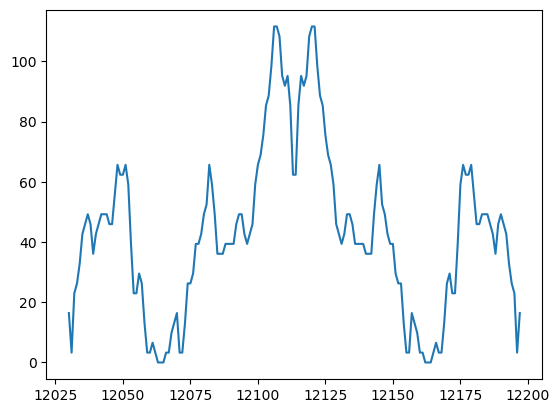

In [11]:
df_new[df_new['ID'] == 56]['Elevation'].plot()
plt.show()

You can see that the profile still has all the main features we saw when we plotted it earlier, although it's somewhat smoother because of the reduced sampling frequency. Don't be alarmed by the x axis values - these simply correspond to the range of rows within the overall dataframe (20,803 in total).

Let's navigate back to our original working directory. We'll save the updated dataframe with max grade values to a new file, and we can drop the Rank and Name fields since we no longer need them for reference (we won't use them for modeling). We'll also save the new dataframe with ID, step, and elevation for analysis with tsfresh.

In [12]:
os.chdir('..')
df.drop(['Rank','Name'],axis=1).to_csv('hiking2.csv',index=False)
df_new.to_csv('hiking_ts.csv',index=False)